# Assignment 2

* In this assignment, we will train a CNN Autoencoder with DX, dental and all-MIAS dataset.
* The result should be compared with conventional denoised methods.
* Comparisons are based on structural similarity index measure(SSIM) and peak signal to noise ratio (PSNR)

# Environment
Use the following lines to import any needed libraries:

In [1]:
import os
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# You may reference to these links below
# Tensorflow api: https://www.tensorflow.org/api_docs/python/tf/keras
# Skimage api: https://scikit-image.org/docs/stable/api/api.html

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# from skimage.restoration import denoise_nl_means, estimate_sigma
# from skimage.metrics import structural_similarity as ssim
# from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy import ndimage

# Utilities

In [2]:
def read_pgm(filename):
    
    """Return image data from a raw PGM file as numpy array.
    Format specification: 
        http://netpbm.sourceforge.net/doc/pgm.html
        https://zh.wikipedia.org/wiki/PBM%E6%A0%BC%E5%BC%8F
    
    Parameters: 
        filename: Specify filename
    Returns:
        np.ndarray[int, int]): 2-D Image array expected each of shape [H, W] 
    """
    
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
#         print('Header:{}\nWidth:{}\nHeight:{}\nMaxval:{}'.format(header, width, height, maxval))
#         print('len {}'.format(len(header)))
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1',
                            count=int(width) * int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [3]:
def show_image(array, random = False):
    
    """Show 10 2-D image from 3-D array 

    Parameters:
        array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        random(bool): Flag determines show image following by index sequence or not.

    """
    n = 10
    if random == True:
        indices = np.random.randint(len(array), size=n)
    else:
        indices = np.arange(n)
    images = array[indices, :]
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(2):
        for j in range(5):
            image = images[i*5+j, :, :]
            axes[i, j].set_title("Index = {}".format(indices[i*5+j]))
            axes[i, j].axis("off")
            axes[i, j].imshow(images[i*5+j].reshape(array.shape[1], array.shape[2]), cmap='gray')
    plt.show()

In [4]:
def read_dental(folder="./data/dental/"):
    images = []
    for filename in sorted(os.listdir(folder), key=lambda x : int(x.split('.')[0])):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

def read_mini_mias(folder="./data/all-mias/"):
    images = np.zeros((322, 1024, 1024))
    i = 0
    for dirName, subdirList, fileList in os.walk(folder):
        for fname in fileList:
            if fname.endswith(".pgm"):
                images[i] = read_pgm(folder + fname)
                i += 1
    return images

def read_dx(folder="data/DX/"):
    images = []
    for filename in sorted(os.listdir(folder), key=lambda x : int(x.split('.')[0])):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

def load_datasets(img_width=256, img_height=256):
    
    """Load datasets with image resize

    Parameters:
        img_width(int): Resize image with img_width
        img_height(int): Resize image with img_height
    Returns:
        mias_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        dx_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        dental_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
    """
    
    
    # Read mias dataset
    raw_mias = read_mini_mias()

    mias_images = np.zeros((raw_mias.shape[0], img_width, img_height))
    for i in range(raw_mias.shape[0]):
        mias_images[i] = cv2.resize(raw_mias[i], dsize=(img_width, img_height),
                                    interpolation=cv2.INTER_AREA)
    # Read dental dataset
    raw_dental = read_dental()  
    dental_images = np.zeros((raw_dental.shape[0], img_width, img_width))
    for i in range(raw_dental.shape[0]):
        dental_images[i] = cv2.resize(raw_dental[i], dsize=(img_width, img_height),
                                      interpolation=cv2.INTER_AREA)
    # Read DX dataset
    raw_dx = read_dx()
    dx_images = np.zeros((raw_dx.shape[0], img_width, img_width))
    for i in range(raw_dx.shape[0]):
        dx_images[i] = cv2.resize(raw_dx[i], dsize=(img_width, img_height),
                                  interpolation=cv2.INTER_AREA)
    
    return mias_images, dx_images, dental_images

In [5]:
def add_noise(array):
 
    """Adds random Guassian noise to each image in the supplied array.

    Parameters:
        array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
    Returns:
        noisy_array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        
    """
    
    noise_factor = 0.1
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [6]:
def train_test_split(mias_images, dx_images, dental_images, train_split=0.9, img_height=256, img_width=256, seed=0):
    
    """Combine datasets and split data into training and testing sets.

    Parameters:
        mias_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        dx_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        dental_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        train_split(float): Proportion of the dataset to include in the training sets
        img_height(int): Height of image
        img_width(int): Width of image
        
    Returns:
        imageset_train(np.ndarray[int, int, int, int]): Training sets, shape [N, H, W, C]
        imageset_test(np.ndarray[int, int, int, int]): Testing sets, shape [N, H, W, C]
    """
    
    np.random.seed(seed)
    np.random.shuffle(mias_images)
    np.random.seed(seed)
    np.random.shuffle(dx_images)
    np.random.seed(seed)
    np.random.shuffle(dental_images)   
    
    imageset_train = mias_images[:int(mias_images.shape[0] * train_split)]
    imageset_train = np.append(imageset_train, dx_images[:int(dx_images.shape[0] * train_split)], axis=0)
    imageset_train = np.append(imageset_train, dental_images[:int(dental_images.shape[0] * train_split)], axis=0)
    
    imageset_test = mias_images[int(mias_images.shape[0] * train_split):]
    imageset_test = np.append(imageset_test, dx_images[int(dx_images.shape[0] * train_split):], axis=0)
    imageset_test = np.append(imageset_test, dental_images[int(dental_images.shape[0] * train_split):], axis=0)
    
    imageset_train = imageset_train.reshape(imageset_train.shape[0], img_height, img_width, 1)
    imageset_test = imageset_test.reshape(imageset_test.shape[0], img_height, img_width, 1)
    
    np.random.seed(seed)
    np.random.shuffle(imageset_train)
    
    return imageset_train, imageset_test

# Data

Load the datasets and display

MIAS dataset


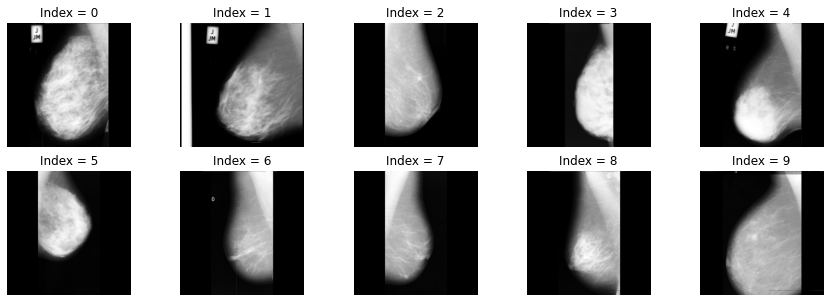

Dental X-ray dataset


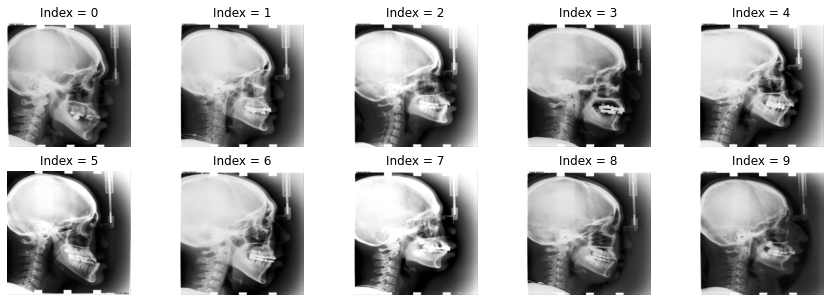

Dental Periapical X-Ray dataset


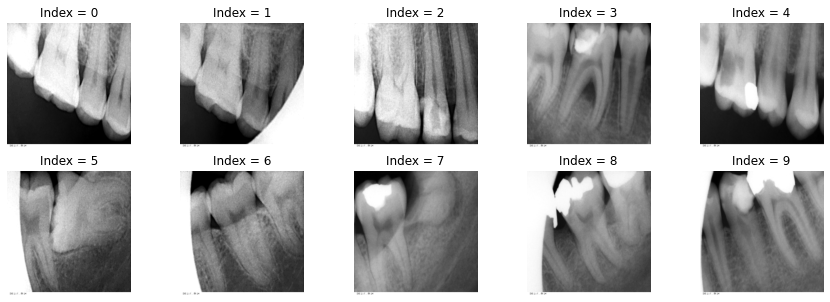

In [7]:
img_width = 256
img_height = 256
mias_images, dx_images, dental_images = load_datasets(img_width, img_height)
print('MIAS dataset')
show_image(mias_images)
print('Dental X-ray dataset')
show_image(dx_images)
print('Dental Periapical X-Ray dataset')
show_image(dental_images)

# Training

## Define the model

In [8]:
def build_model(img_width=256, img_height=256):
    
    """Build customized model 

    Parameters:
        img_width(int): Specify input image shape
        img_height(int): Specify input image shape
    Returns:
        model

    """
    autoencoder = keras.Sequential()
    # Encoder
    autoencoder.add(keras.Input(shape=(img_width, img_height, 1)))
    autoencoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    # Decoder
    autoencoder.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.UpSampling2D((2, 2)))
    autoencoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.UpSampling2D((2, 2)))
    autoencoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.UpSampling2D((2, 2)))
    autoencoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    autoencoder.summary()

    
#     autoencoder = keras.Sequential()
#     # Encoder
#     autoencoder.add(keras.Input(shape=(img_width, img_height, 1)))
#     autoencoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
#     autoencoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
#     autoencoder.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
#     # Decoder
#     autoencoder.add(layers.Conv2DTranspose(256, (3, 3), activation="relu", padding="same"))
#     autoencoder.add(layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same"))
#     autoencoder.add(layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same"))
#     autoencoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
#     autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
#     autoencoder.summary()
    
    img_file = './model_arch.png'

    keras.utils.plot_model(autoencoder, to_file=img_file, show_shapes=True, show_layer_names=True)
    
    return autoencoder

#     model = keras.Sequential()
#     model.add(keras.Input(shape=(img_height, img_width, 1)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None), padding='same', use_bias=True, bias_initializer='zeros'))
# #     for i in range(2,16+1):
#     for i in range(18):
#         model.add(layers.Conv2D(64,(3,3), kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None), padding="same", use_bias=True, bias_initializer='zeros'))
#         model.add(layers.BatchNormalization())
#         model.add(layers.Activation('relu'))
#     model.add(layers.Conv2D(1,(3,3), activation='sigmoid', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None), padding="same", use_bias=True, bias_initializer='zeros'))
#     model.compile(optimizer=Adam(), loss='binary_crossentropy')
#     model.summary()
#     return model

In [9]:
model = build_model(img_width, img_height)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       5

## Splitting dataset

In [20]:
mias_images.shape

(322, 256, 256)

In [21]:
dx_images.shape

(400, 256, 256)

In [22]:
dental_images.shape

(120, 256, 256)

In [10]:
seed = 0
input_train, input_test = train_test_split(mias_images, dx_images, dental_images, 0.9, img_height, img_width, seed)

In [11]:
input_train.shape

(757, 256, 256, 1)

In [12]:
input_test.shape

(85, 256, 256, 1)

Input image


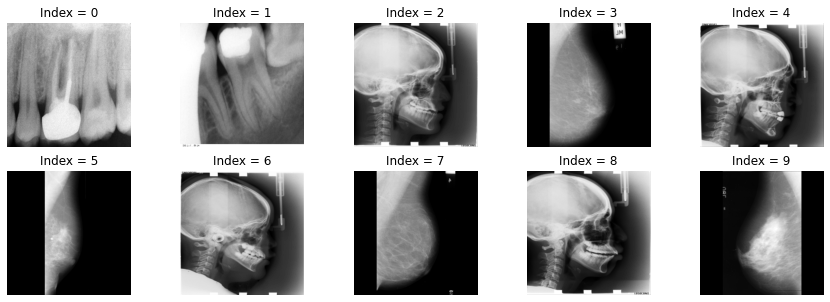

In [13]:
print("Input image")
show_image(input_train)

## Prepare data
* Scale images to the [0, 1] range
* Add noise

In [14]:
# Scale images to the [0, 1] range
input_train = input_train.astype("float32") / 255
input_test = input_test.astype("float32") / 255
noisy_train = add_noise(input_train)
noisy_test = add_noise(input_test)

Noisy image


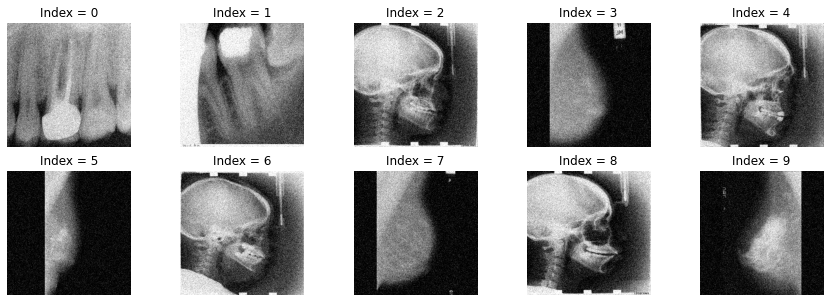

In [15]:
print("Noisy image")
show_image(noisy_train)

## Model fitting with dataset

Epoch 1/50
171/171 [==============================] - 6s 24ms/step - loss: 0.4871 - val_loss: 0.4146
Epoch 2/50
171/171 [==============================] - 3s 19ms/step - loss: 0.4133 - val_loss: 0.4102
Epoch 3/50
171/171 [==============================] - 3s 19ms/step - loss: 0.4156 - val_loss: 0.4089
Epoch 4/50
171/171 [==============================] - 3s 20ms/step - loss: 0.4154 - val_loss: 0.4088
Epoch 5/50
171/171 [==============================] - 3s 20ms/step - loss: 0.4151 - val_loss: 0.4085
Epoch 6/50
171/171 [==============================] - 4s 21ms/step - loss: 0.4186 - val_loss: 0.4115
Epoch 7/50
171/171 [==============================] - 3s 20ms/step - loss: 0.4138 - val_loss: 0.4078
Epoch 8/50
171/171 [==============================] - 3s 20ms/step - loss: 0.4159 - val_loss: 0.4085
Epoch 9/50
171/171 [==============================] - 4s 21ms/step - loss: 0.4218 - val_loss: 0.4079
Epoch 10/50
171/171 [==============================] - 3s 19ms/step - loss: 0.4140 - val_lo

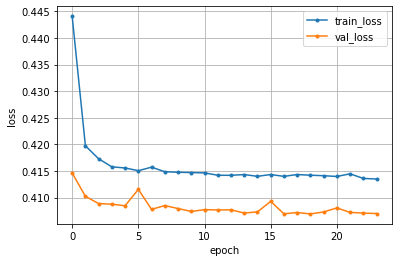

In [16]:
es = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(
    noisy_train,
    input_train,
    epochs = 50,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.1,
    verbose = 1,
    callbacks=[es]
)

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='train_loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluation

Noisy test image


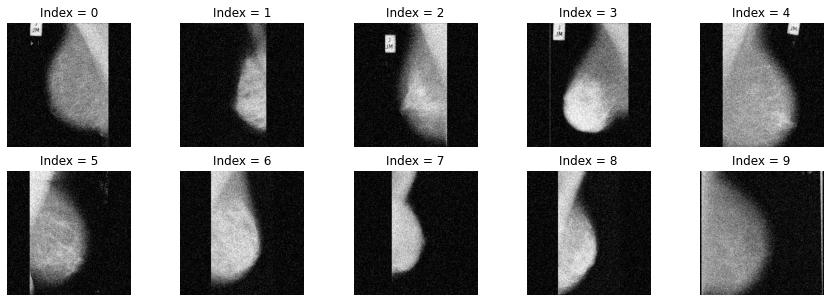

Denoised test image


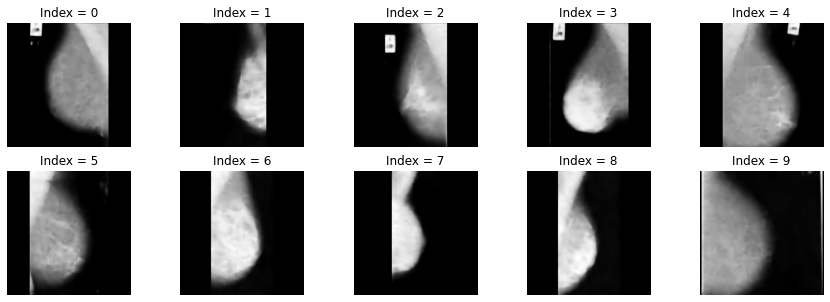

In [17]:
denoised_images = model.predict(noisy_test)
print('Noisy test image')
show_image(noisy_test)
print('Denoised test image')
show_image(denoised_images)

In [18]:
def plot_samples(input_test, noisy_test, denoised_images, numofrow=4, img_width=256, img_height=256):
    fig, axes = plt.subplots(numofrow, 5, figsize=(25,10*numofrow/2))

    indices = np.random.randint(len(input_test), size=numofrow)
    
    # Set axes titles
    axes[0][0].set_title('Original image')
    axes[0][1].set_title('Noisy image')
    axes[0][2].set_title('Autoencoder')
#     axes[0][3].set_title('Median filter')
    axes[0][3].set_title('Lowpass filter')
    axes[0][4].set_title('NLMeans filter')
    
    # Plot denoised images
    noisy_images = []
    pure_images = []
    autoencode_images = []
    median_images = []
    nlm_images = []
    lowpass_images = []
    
    for i in range(0, len(input_test)):
        # Get the sample and the reconstruction
        noisy_image = noisy_test[i][:, :, 0]
        pure_image = input_test[i][:, :, 0]
        denoised_image = denoised_images[i][:, :, 0]
        median_image = apply_median_filter(noisy_test[i].reshape(img_height, img_width))
        nlm_denoised = apply_nlm_filter(noisy_test[i].reshape(img_height, img_width))
        lowpass_denoised = apply_lowpass_filter(noisy_test[i].reshape(img_height, img_width))
        noisy_images.append(noisy_image)
        pure_images.append(pure_image)
        autoencode_images.append(denoised_image)
        median_images.append(median_image)
        nlm_images.append(nlm_denoised)
        lowpass_images.append(lowpass_denoised)

    noisy_images = np.array(noisy_images)
    pure_images = np.array(pure_images)
    autoencode_images = np.array(autoencode_images)
    median_images = np.array(median_images)
    nlm_images = np.array(nlm_images)
    lowpass_images = np.array(lowpass_images)
    
#     print("SSIM result:\nNoisy:{:.2f}, Autoencoder:{:.2f}, Median:{:.2f}, NLMeans:{:.2f}"
#           .format(calculate_set_ssim(pure_images, noisy_images, img_width, img_height),
#                   calculate_set_ssim(pure_images, denoised_images, img_width, img_height),
#                   calculate_set_ssim(pure_images, median_images, img_width, img_height),
#                   calculate_set_ssim(pure_images, nlm_images, img_width, img_height)))
#     print("PSNR result:\nNoisy:{:.2f}, Autoencoder:{:.2f}, Median:{:.2f}, NLMeans:{:.2f}"
#           .format(calculate_set_psnr(pure_images, noisy_images, img_width, img_height),
#                   calculate_set_psnr(pure_images, denoised_images, img_width, img_height),
#                   calculate_set_psnr(pure_images, median_images, img_width, img_height),
#                   calculate_set_psnr(pure_images, nlm_images, img_width, img_height)))

    print("SSIM result:\nNoisy:{:.2f}, Autoencoder:{:.2f}, Lowpass:{:.2f}, NLMeans:{:.2f}"
          .format(calculate_set_ssim(pure_images, noisy_images, img_width, img_height),
                  calculate_set_ssim(pure_images, denoised_images, img_width, img_height),
                  calculate_set_ssim(pure_images, lowpass_images, img_width, img_height),
                  calculate_set_ssim(pure_images, nlm_images, img_width, img_height)))
    print("PSNR result:\nNoisy:{:.2f}, Autoencoder:{:.2f}, Lowpass:{:.2f}, NLMeans:{:.2f}"
          .format(calculate_set_psnr(pure_images, noisy_images, img_width, img_height),
                  calculate_set_psnr(pure_images, denoised_images, img_width, img_height),
                  calculate_set_psnr(pure_images, lowpass_images, img_width, img_height),
                  calculate_set_psnr(pure_images, nlm_images, img_width, img_height)))
    
    for i in range(0, numofrow):
        # Plot sample and reconstruction
        noisy_image = noisy_images[indices[i]]
        pure_image = pure_images[indices[i]]
        denoised_image = autoencode_images[indices[i]]
        median_image = median_images[indices[i]]
        nlm_denoised = nlm_images[indices[i]]
        lowpass_denoised = lowpass_images[indices[i]]
        
        axes[i][0].imshow(pure_image, plt.cm.gray)
        axes[i][0].set_xlabel("SSIM: {:.2f}".format(calculate_image_ssim(pure_image, pure_image))) 
                                                        
        axes[i][1].imshow(noisy_image, plt.cm.gray)
        axes[i][1].set_xlabel("SSIM: {:.2f}\nPSNR: {:.2f}dB".format(calculate_image_ssim(pure_image, noisy_image), 
                                                                  calculate_image_psnr(pure_image, noisy_image)))
        axes[i][2].imshow(denoised_image, plt.cm.gray)
        axes[i][2].set_xlabel("SSIM: {:.2f}\nPSNR: {:.2f}dB".format(calculate_image_ssim(pure_image, denoised_image),
                                                                  calculate_image_psnr(pure_image, denoised_image)))
#         axes[i][3].imshow(median_image, plt.cm.gray)
#         axes[i][3].set_xlabel("SSIM: {:.2f}\nPSNR: {:.2f}dB".format(calculate_image_ssim(pure_image, median_image), 
#                                                                   calculate_image_psnr(pure_image, median_image)))
        axes[i][3].imshow(lowpass_denoised, plt.cm.gray)
        axes[i][3].set_xlabel("SSIM: {:.2f}\nPSNR: {:.2f}dB".format(calculate_image_ssim(pure_image, lowpass_denoised), 
                                                                  calculate_image_psnr(pure_image, lowpass_denoised)))
        axes[i][4].imshow(nlm_denoised, plt.cm.gray)
        axes[i][4].set_xlabel("SSIM: {:.2f}\nPSNR: {:.2f}dB".format(calculate_image_ssim(pure_image, nlm_denoised), 
                                                                  calculate_image_psnr(pure_image, nlm_denoised)))
    plt.show() 
    
def apply_median_filter(image, kernel_size = 5):
#     print("Image denoised using Mean filter")
    return ndimage.median_filter(image, size=kernel_size)
def apply_nlm_filter(image):
#     print("Image denoised using NL Means")
    sigma_est = np.mean(estimate_sigma(image, multichannel=False))
    denoised_image = denoise_nl_means(image, h=1.*sigma_est)
    return denoised_image
def apply_lowpass_filter(image):
    ham = np.hamming(image.shape[0])[:,None]
    ham2d = np.sqrt(np.dot(ham, ham.T)) ** 2
    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
    f_filtered = ham2d * f_complex
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    return filtered_img
def calculate_image_ssim(original_img, noisy_img):
    return ssim(original_img, noisy_img, data_range=1)
def calculate_image_psnr(original_img, noisy_img):
    return psnr(original_img, noisy_img, data_range=1)
def calculate_set_ssim(originalSet, noisySet, img_width=256, img_height=256):
    ssim_sum = 0
    originalSet = originalSet.reshape(originalSet.shape[0], img_height, img_width)
    noisySet = noisySet.reshape(noisySet.shape[0], img_height, img_width)
    for i in range(originalSet.shape[0]):
        ssim_sum += ssim(originalSet[i], noisySet[i], data_range=1)
    return ssim_sum/originalSet.shape[0]
def calculate_set_psnr(originalSet, noisySet, img_width=256, img_height=256):
    psnr_sum = 0
    originalSet = originalSet.reshape(originalSet.shape[0], img_height, img_width)
    noisySet = noisySet.reshape(noisySet.shape[0], img_height, img_width)
    for i in range(originalSet.shape[0]):
        psnr_sum += psnr(originalSet[i], noisySet[i], data_range=1)
    return psnr_sum/originalSet.shape[0]

SSIM result:
Noisy:0.24, Autoencoder:0.89, Lowpass:0.51, NLMeans:0.67
PSNR result:
Noisy:20.93, Autoencoder:32.40, Lowpass:26.74, NLMeans:29.30


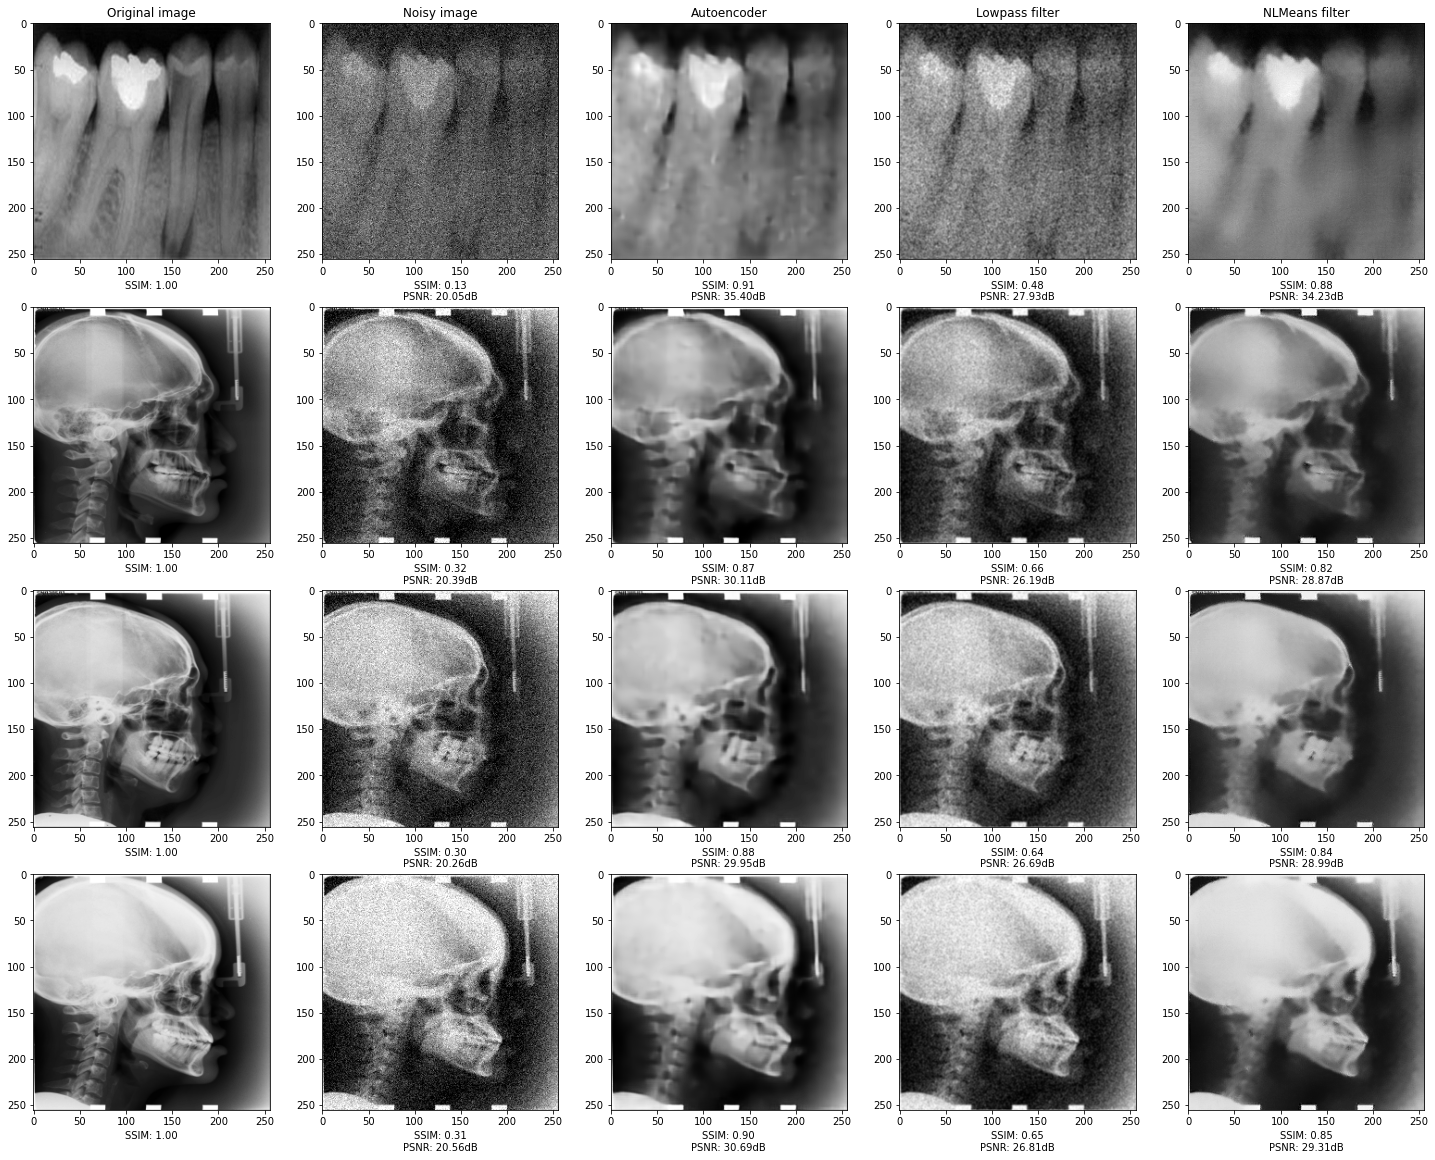

In [19]:
plot_samples(input_test, noisy_test, denoised_images, 4, img_width, img_height)